In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gameal1/rejected_2007_to_2018Q4.csv
/kaggle/input/gameal/accepted_2007_to_2018Q4.csv


# Task 1: Exploratory Data Analysis (EDA) and Preprocessing

In [3]:
# ============================
# 1. IMPORTS & CONFIG
# ============================

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# ML / preprocessing
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.ensemble import HistGradientBoostingClassifier

# Deep learning
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Plot style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)
pd.set_option("display.max_columns", 200)


In [4]:
# ============================
# 2. LOAD DATA
# ============================

# Change this path if your file is elsewhere
DATA_PATH = "/kaggle/input/gameal/accepted_2007_to_2018Q4.csv"   # or .csv.gz, pandas will infer

# For faster dev, we limit rows; you can increase later if RAM allows
USE_NROWS = 500_000

df = pd.read_csv(DATA_PATH, nrows=USE_NROWS, low_memory=False)
print("Shape:", df.shape)

print("\nHEAD:")
display(df.head())

print("\nINFO:")
print(df.info())

print("\nNUMERIC DESCRIBE (subset):")
display(df.select_dtypes(include=[np.number]).describe().T.head(10))


Shape: (500000, 151)

HEAD:


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,N


INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 576.0+ MB
None

NUMERIC DESCRIBE (subset):


,count,mean,std,min,25%,50%,75%,max
member_id,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_amnt,499998.0,15388.960556,8852.271158,1000.00,8500.00,14000.00,20000.00,40000.00
funded_amnt,499998.0,15388.960556,8852.271158,1000.00,8500.00,14000.00,20000.00,40000.00
funded_amnt_inv,499998.0,15383.220733,8849.356048,900.00,8500.00,14000.00,20000.00,40000.00
int_rate,499998.0,12.574207,4.438228,5.31,9.17,12.29,15.59,30.99
installment,499998.0,446.388830,252.569027,14.01,262.75,385.91,589.22,1607.80
annual_inc,499998.0,77186.320380,75346.637075,0.00,46000.00,65000.00,92000.00,9500000.00
dti,499782.0,19.245352,12.055632,0.00,12.39,18.47,25.31,999.00
delinq_2yrs,499998.0,0.328035,0.900866,0.00,0.00,0.00,0.00,39.00
fico_range_low,499998.0,695.932524,31.800548,660.00,670.00,690.00,710.00,845.00


In [5]:
# ============================
# 3. CREATE BINARY TARGET
# ============================

GOOD = ["Fully Paid"]
BAD  = ["Charged Off", "Default", "Late (31-120 days)", "Late (16-30 days)"]

df["target"] = np.nan
df.loc[df["loan_status"].isin(GOOD), "target"] = 0
df.loc[df["loan_status"].isin(BAD),  "target"] = 1

before = len(df)
df = df[df["target"].notna()].copy()
after = len(df)

df["target"] = df["target"].astype(int)

print(f"Dropped {before - after} rows with ambiguous / non-final loan_status")
print("\nTarget distribution:")
print(df["target"].value_counts(normalize=True))


Dropped 105288 rows with ambiguous / non-final loan_status

Target distribution:
target
0    0.791311
1    0.208689
Name: proportion, dtype: float64


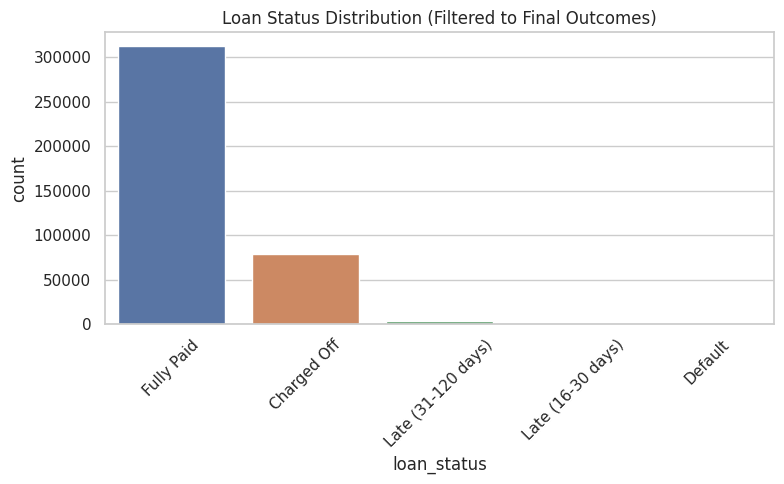

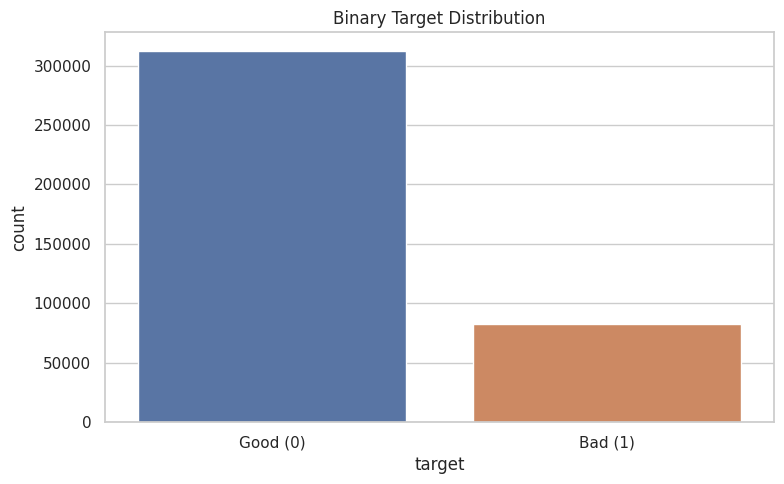

In [6]:
# ============================
# 4. BASIC EDA: TARGET & LOAN STATUS
# ============================

# Loan status distribution for all filtered rows
plt.figure()
sns.countplot(x="loan_status", data=df, order=df["loan_status"].value_counts().index)
plt.xticks(rotation=45)
plt.title("Loan Status Distribution (Filtered to Final Outcomes)")
plt.tight_layout()
plt.show()

# Target distribution (0 = good, 1 = bad)
plt.figure()
sns.countplot(x="target", data=df)
plt.xticks([0,1], ["Good (0)", "Bad (1)"])
plt.title("Binary Target Distribution")
plt.tight_layout()
plt.show()


In [7]:
# ============================
# 5. SAMPLE FOR EDA
# ============================

EDA_N = min(50_000, len(df))
df_eda = df.sample(n=EDA_N, random_state=42)

print("EDA sample shape:", df_eda.shape)


EDA sample shape: (50000, 152)


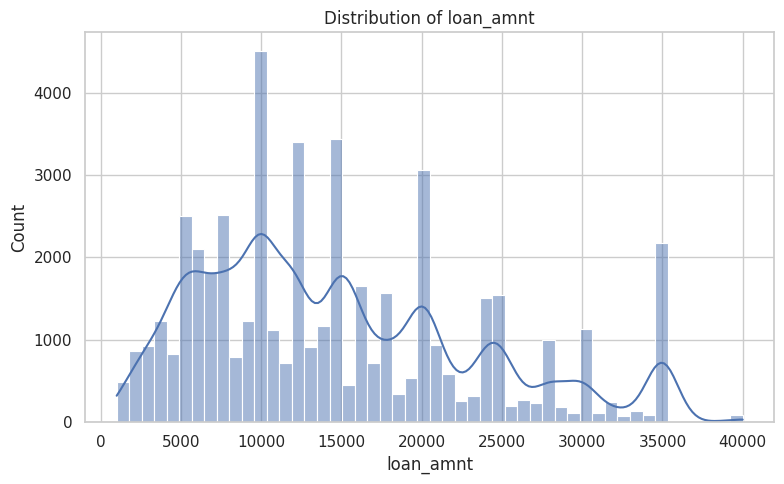

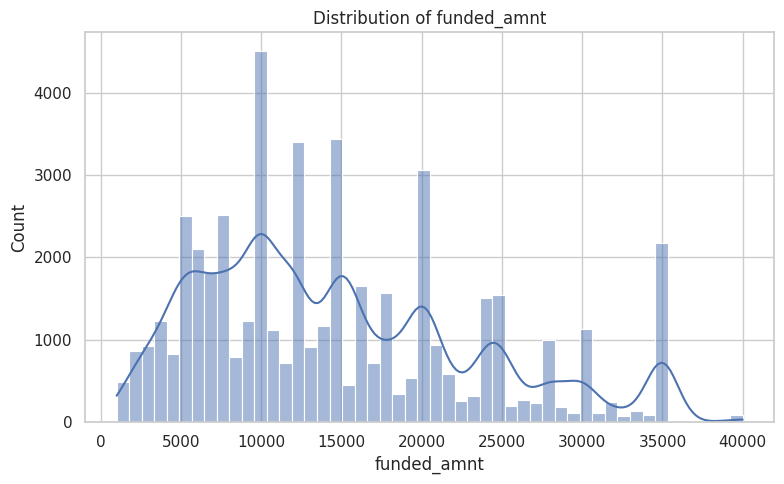

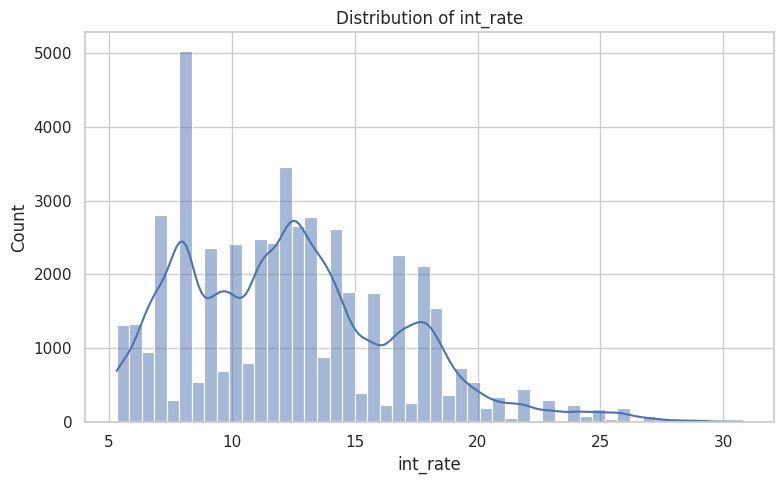

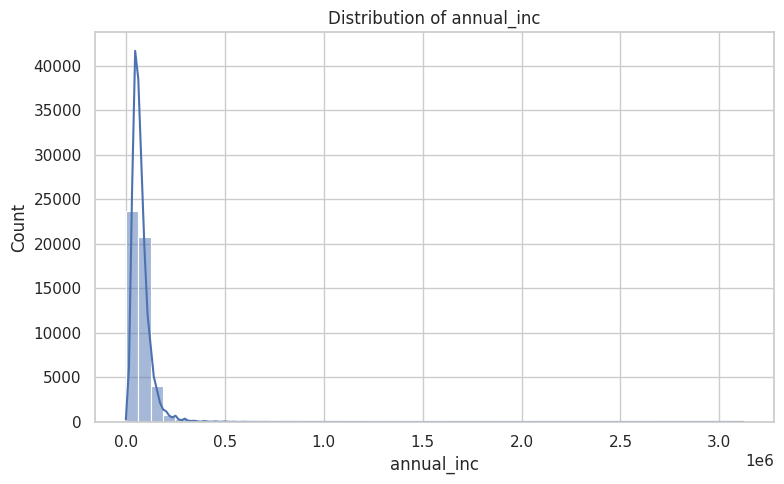

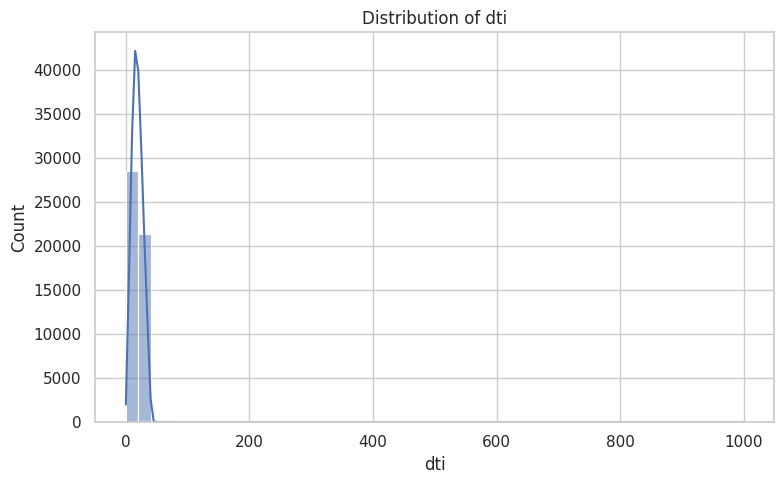

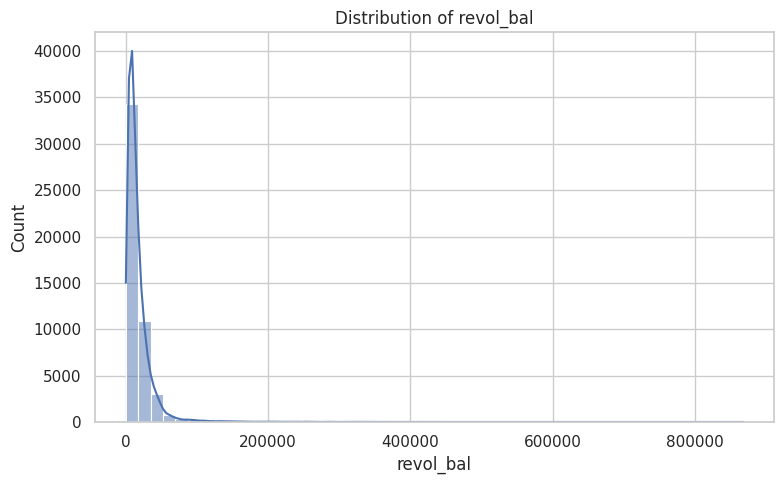

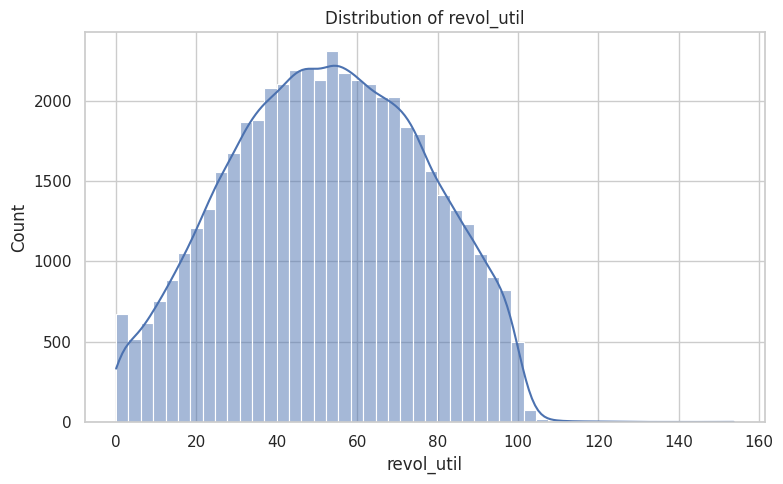

In [8]:
# ============================
# 6. NUMERICAL EDA
# ============================

num_cols_to_plot = [
    "loan_amnt",
    "funded_amnt",
    "int_rate",
    "annual_inc",
    "dti",
    "revol_bal",
    "revol_util"
]

for col in num_cols_to_plot:
    if col in df_eda.columns:
        plt.figure()
        sns.histplot(df_eda[col].dropna(), kde=True, bins=50)
        plt.title(f"Distribution of {col}")
        plt.tight_layout()
        plt.show()


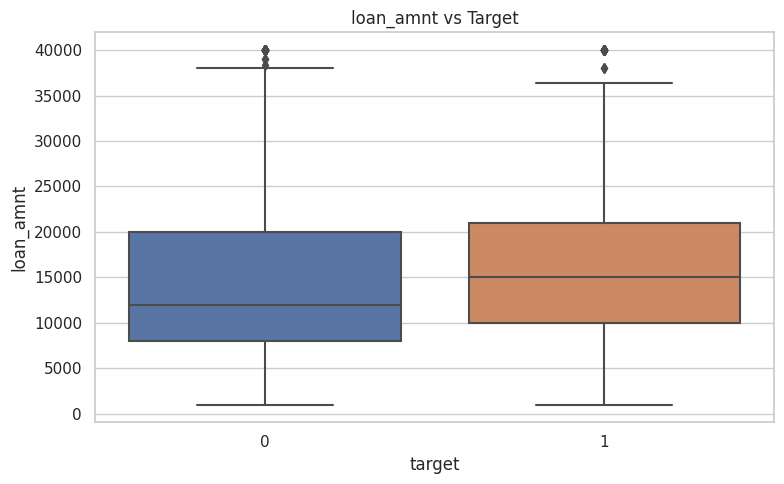

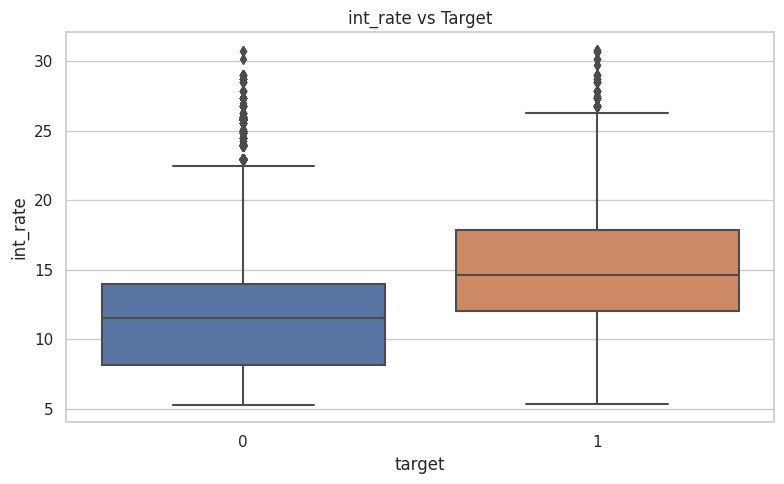

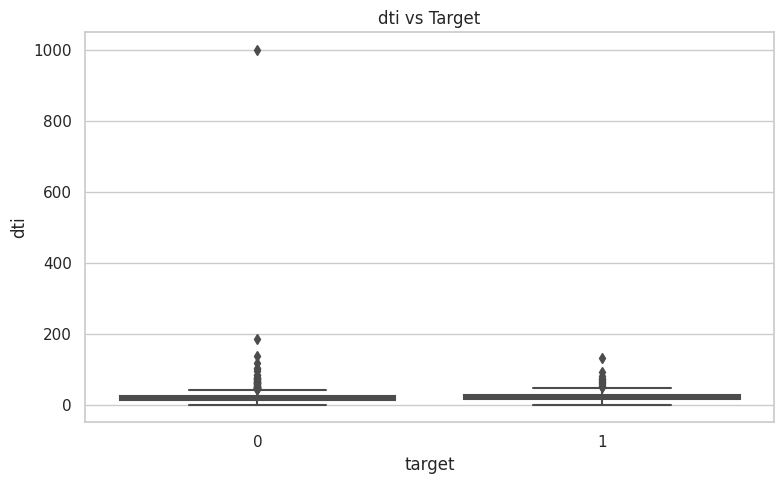

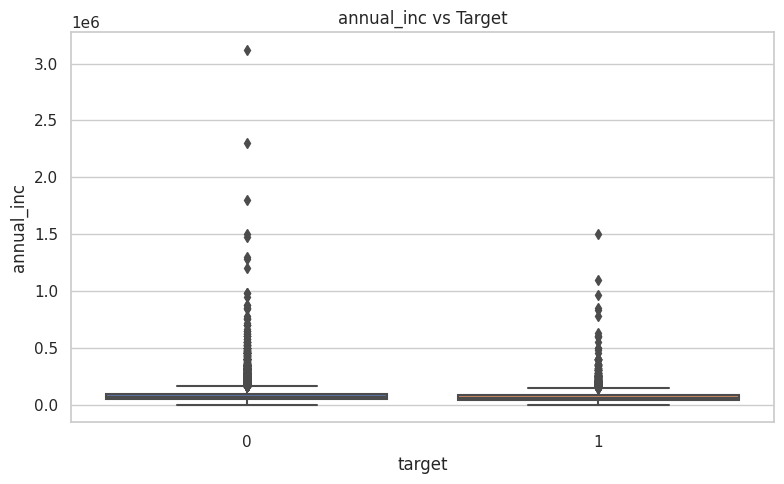

In [9]:
for col in ["loan_amnt", "int_rate", "dti", "annual_inc"]:
    if col in df_eda.columns:
        plt.figure()
        sns.boxplot(x="target", y=col, data=df_eda)
        plt.title(f"{col} vs Target")
        plt.tight_layout()
        plt.show()


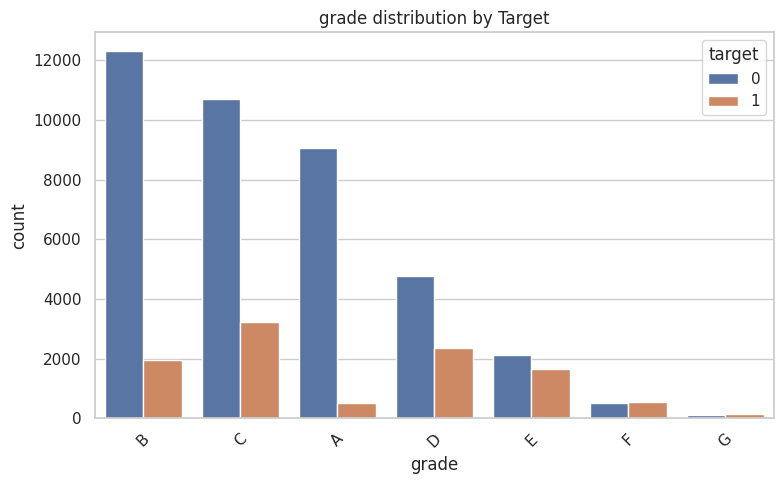

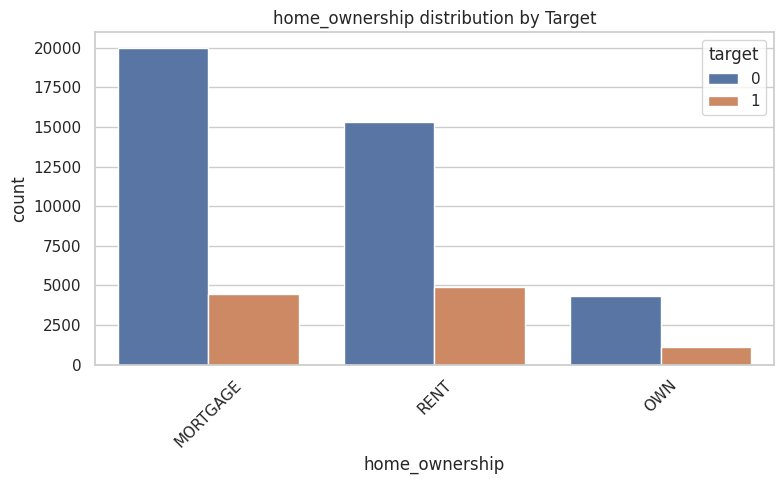

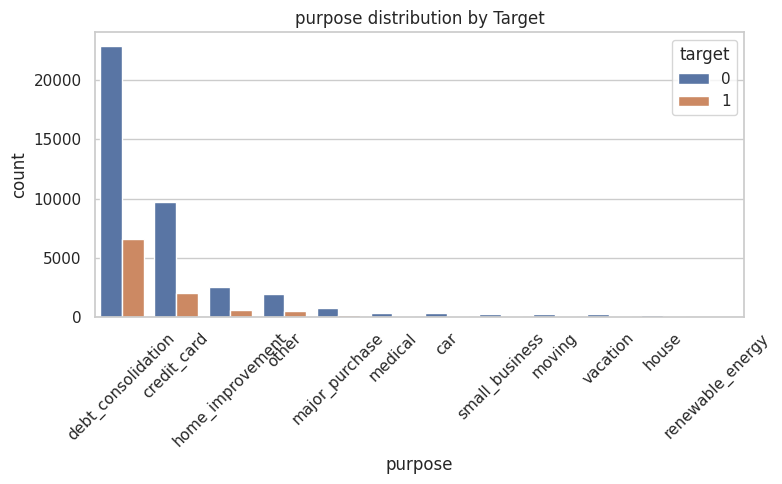

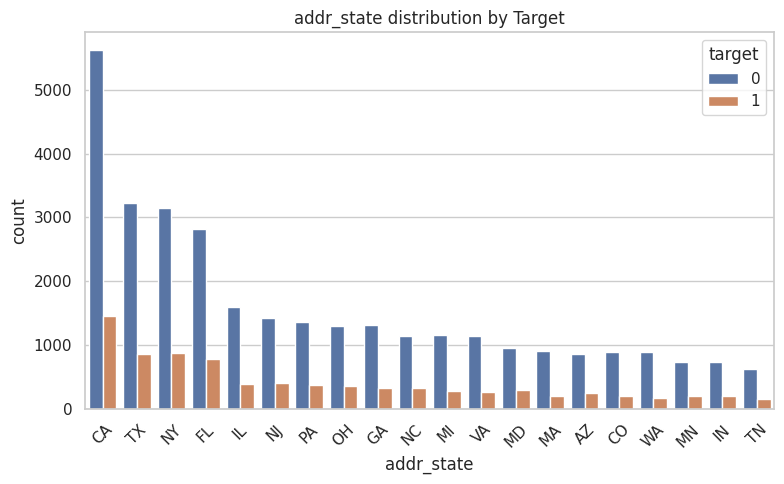

In [10]:
# ============================
# 7. CATEGORICAL EDA
# ============================

cat_cols_to_plot = [
    "grade",
    "home_ownership",
    "purpose",
    "addr_state"
]

for col in cat_cols_to_plot:
    if col in df_eda.columns:
        plt.figure()
        order = df_eda[col].value_counts().index[:20]  # top 20 if many categories
        sns.countplot(data=df_eda, x=col, order=order, hue="target")
        plt.title(f"{col} distribution by Target")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


### Missing Value Analysis

Several features contain missing values. To decide an appropriate handling strategy,
we inspected the percentage of missing data per column.

- Columns with more than 40% missing values were dropped, as they are unlikely to provide reliable signals.
- Numerical columns with small missing percentages were imputed using the median to avoid outlier influence.
- Categorical columns were imputed using a new category "Unknown".


Top 20 columns by missing fraction:


member_id                                     1.000000
desc                                          0.999894
sec_app_mths_since_last_major_derog           0.997621
orig_projected_additional_accrued_interest    0.995668
hardship_type                                 0.994439
hardship_reason                               0.994439
hardship_status                               0.994439
deferral_term                                 0.994439
hardship_amount                               0.994439
hardship_start_date                           0.994439
hardship_end_date                             0.994439
payment_plan_start_date                       0.994439
hardship_length                               0.994439
hardship_dpd                                  0.994439
hardship_loan_status                          0.994439
hardship_payoff_balance_amount                0.994439
hardship_last_payment_amount                  0.994439
sec_app_revol_util                            0.993712
sec_app_mo

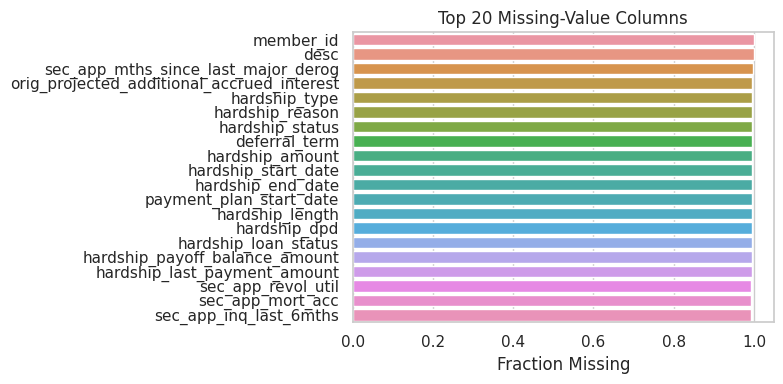

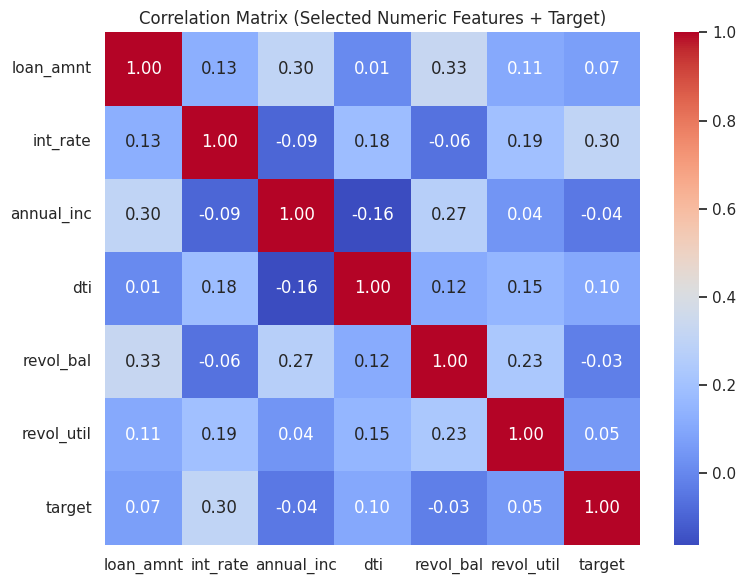

In [11]:
# ============================
# 8. MISSING VALUES & CORRELATIONS
# ============================

# Missing values (top 20)
missing = df.isna().mean().sort_values(ascending=False).head(20)
print("Top 20 columns by missing fraction:")
display(missing)

plt.figure(figsize=(8, 4))
sns.barplot(x=missing.values, y=missing.index)
plt.title("Top 20 Missing-Value Columns")
plt.xlabel("Fraction Missing")
plt.tight_layout()
plt.show()

# Correlation of some numeric columns with the target
num_for_corr = [
    "loan_amnt", "int_rate", "annual_inc", "dti",
    "revol_bal", "revol_util"
]

corr_df = df[num_for_corr + ["target"]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix (Selected Numeric Features + Target)")
plt.tight_layout()
plt.show()


### Feature Selection Rationale

From the original dataset, we selected features that reflect:
- Applicant financial strength (e.g., annual income, debt-to-income ratio)
- Loan characteristics (e.g., loan amount, interest rate, term)
- Credit history indicators (e.g., open accounts, delinquencies)

Highly leakage-prone columns (e.g., post-loan status variables) were removed to avoid
using information not available at decision time.


In [12]:
# ============================
# 9. FEATURE ENGINEERING
# ============================

df_fe = df.copy()

# 9.1 issue_d → year, month
df_fe["issue_d_year"] = pd.to_datetime(df_fe["issue_d"], format="%b-%Y", errors="coerce").dt.year
df_fe["issue_d_month"] = pd.to_datetime(df_fe["issue_d"], format="%b-%Y", errors="coerce").dt.month

# 9.2 earliest_cr_line → earliest_year, credit_history_length
df_fe["earliest_year"] = pd.to_datetime(
    df_fe["earliest_cr_line"], format="%b-%Y", errors="coerce"
).dt.year

# Fix future years like 2069 (interpret as 1969)
max_issue_year = df_fe["issue_d_year"].max()
mask_future = df_fe["earliest_year"] > max_issue_year
df_fe.loc[mask_future, "earliest_year"] = df_fe.loc[mask_future, "earliest_year"] - 100

df_fe["credit_history_length"] = df_fe["issue_d_year"] - df_fe["earliest_year"]

# 9.3 emp_length_clean → numeric years
def clean_emp_length(v):
    if pd.isna(v):
        return np.nan
    v = str(v)
    if v == "10+ years":
        return 10
    if v == "< 1 year":
        return 0
    try:
        return int(v.split()[0])
    except:
        return np.nan

df_fe["emp_length_clean"] = df_fe["emp_length"].apply(clean_emp_length)

# 9.4 term_clean → numeric months
df_fe["term_clean"] = df_fe["term"].str.extract(r"(\d+)").astype(float)

# 9.5 Grade and sub_grade ordinal encoding
grade_map = {g: i for i, g in enumerate("ABCDEFG", 1)}
df_fe["grade_ord"] = df_fe["grade"].map(grade_map)

def encode_sub_grade(s):
    if pd.isna(s):
        return np.nan
    g = s[0]
    n = int(s[1])
    return grade_map.get(g, np.nan) * 5 + n

df_fe["sub_grade_ord"] = df_fe["sub_grade"].apply(encode_sub_grade)

# 9.6 Ratio features (avoid division by zero)
annual_inc_safe = df_fe["annual_inc"].replace(0, np.nan)

df_fe["loan_to_income"] = df_fe["loan_amnt"] / annual_inc_safe
df_fe["installment_to_income"] = df_fe["installment"] / annual_inc_safe

print("Feature engineering done.")


Feature engineering done.


In [13]:
# ============================
# 10. FINAL FEATURE LISTS
# ============================

NUMERIC = [
    "loan_amnt","funded_amnt","funded_amnt_inv",
    "int_rate","installment","annual_inc",
    "dti","delinq_2yrs","inq_last_6mths","open_acc",
    "pub_rec","revol_bal","revol_util","total_acc",
    "pub_rec_bankruptcies",
    "issue_d_year","issue_d_month","credit_history_length",
    "emp_length_clean","term_clean",
    "grade_ord","sub_grade_ord",
    "loan_to_income","installment_to_income",
]

CATEGORICAL = [
    "home_ownership","verification_status",
    "purpose","addr_state","application_type"
]

ALL_FEATURES = NUMERIC + CATEGORICAL

df_model = df_fe[ALL_FEATURES + ["target"]].copy()
print("df_model shape:", df_model.shape)


df_model shape: (394712, 30)


### Data Cleaning and Preprocessing

The following preprocessing steps were applied:

1. Missing Values:
   - Numerical features were imputed using median values.
   - Categorical features were imputed using the category "Unknown".

2. Categorical Encoding:
   - Ordinal features (e.g., grade) were label-encoded.
   - Nominal categorical variables were one-hot encoded.

3. Feature Scaling:
   - Numerical features were scaled using StandardScaler to stabilize neural network training.


In [14]:
# ============================
# 11. CLEANING INF, OUTLIERS, NANS
# ============================

# Replace infinities with NaN
df_model = df_model.replace([np.inf, -np.inf], np.nan)

# Clip numeric outliers to reasonable ranges
df_model["dti"] = df_model["dti"].clip(0, 100)
df_model["revol_util"] = df_model["revol_util"].clip(0, 150)
df_model["loan_to_income"] = df_model["loan_to_income"].clip(0, 5)
df_model["installment_to_income"] = df_model["installment_to_income"].clip(0, 5)
df_model["credit_history_length"] = df_model["credit_history_length"].clip(0, 60)

# Fill categorical NaNs with "Missing"
for col in CATEGORICAL:
    df_model[col] = df_model[col].fillna("Missing")

print("Any remaining inf in numeric?", np.isinf(df_model[NUMERIC]).any().any())


Any remaining inf in numeric? False


# Task 2

### Data Splitting Strategy

To evaluate generalization performance, the dataset was split into training, validation,
and test sets using stratified sampling to preserve class imbalance.
All reported metrics are computed on the held-out test set.


In [15]:
# ============================
# 12. TRAIN / VAL / TEST SPLIT
# ============================

X = df_model[ALL_FEATURES]
y = df_model["target"].values

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Train: (276298, 29) Val: (59207, 29) Test: (59207, 29)


In [16]:
# ============================
# 13. PREPROCESSING PIPELINE
# ============================

numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, NUMERIC),
    ("cat", categorical_pipeline, CATEGORICAL)
])

preprocessor.fit(X_train)

X_train_p = preprocessor.transform(X_train)
X_val_p   = preprocessor.transform(X_val)
X_test_p  = preprocessor.transform(X_test)

print("Transformed shapes:")
print(X_train_p.shape, X_val_p.shape, X_test_p.shape)


Transformed shapes:
(276298, 96) (59207, 96) (59207, 96)


In [17]:
# ============================
# 14. TORCH TENSORS & DATALOADERS
# ============================

# ColumnTransformer returns a NumPy array here (dense)
X_train_t = torch.tensor(X_train_p, dtype=torch.float32)
X_val_t   = torch.tensor(X_val_p, dtype=torch.float32)
X_test_t  = torch.tensor(X_test_p, dtype=torch.float32)

y_train_t = torch.tensor(y_train, dtype=torch.float32)
y_val_t   = torch.tensor(y_val, dtype=torch.float32)
y_test_t  = torch.tensor(y_test, dtype=torch.float32)

class LoanDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = LoanDataset(X_train_t, y_train_t)
val_ds   = LoanDataset(X_val_t, y_val_t)
test_ds  = LoanDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=2048, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=4096, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=4096, shuffle=False)

print("Tensor shapes:", X_train_t.shape, y_train_t.shape)


Tensor shapes: torch.Size([276298, 96]) torch.Size([276298])


In [18]:
# ============================
# 15. MLP MODEL
# ============================

class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.ReLU(),

            nn.Linear(128, 1)   # output logit
        )

    def forward(self, x):
        return self.model(x)

input_dim = X_train_t.shape[1]
model = MLP(input_dim)
model


MLP(
  (model): Sequential(
    (0): Linear(in_features=96, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [19]:
# ============================
# 16. TRAIN NN WITH EARLY STOPPING
# ============================

pos_weight = torch.tensor([len(y_train) / y_train.sum()], dtype=torch.float32)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

best_auc = 0.0
best_state = None
patience = 5
wait = 0

for epoch in range(50):
    model.train()
    total_loss = 0.0

    for Xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model(Xb).squeeze()
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation
    model.eval()
    val_probs = []
    val_true = []

    with torch.no_grad():
        for Xb, yb in val_loader:
            preds = model(Xb).squeeze().sigmoid()
            val_probs.append(preds.cpu().numpy())
            val_true.append(yb.cpu().numpy())

    val_probs = np.concatenate(val_probs)
    val_true = np.concatenate(val_true)

    val_auc = roc_auc_score(val_true, val_probs)
    print(f"Epoch {epoch+1} | Loss {total_loss:.2f} | Val AUC {val_auc:.4f}")

    if val_auc > best_auc:
        best_auc = val_auc
        best_state = model.state_dict()
        torch.save(best_state, "best_nn_model.pth") 
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping.")
            break


model.load_state_dict(best_state)
print("Best Validation AUC:", best_auc)


Epoch 1 | Loss 145.22 | Val AUC 0.7381
Epoch 2 | Loss 143.74 | Val AUC 0.7393
Epoch 3 | Loss 143.28 | Val AUC 0.7395
Epoch 4 | Loss 143.04 | Val AUC 0.7403
Epoch 5 | Loss 142.80 | Val AUC 0.7402
Epoch 6 | Loss 142.56 | Val AUC 0.7396
Epoch 7 | Loss 142.39 | Val AUC 0.7408
Epoch 8 | Loss 142.20 | Val AUC 0.7398
Epoch 9 | Loss 142.06 | Val AUC 0.7409
Epoch 10 | Loss 141.91 | Val AUC 0.7406
Epoch 11 | Loss 141.61 | Val AUC 0.7405
Epoch 12 | Loss 141.58 | Val AUC 0.7405
Epoch 13 | Loss 141.40 | Val AUC 0.7402
Epoch 14 | Loss 141.28 | Val AUC 0.7402
Early stopping.
Best Validation AUC: 0.7408603512541315


In [20]:
# ============================
# 17. EVALUATE NN (AUC + F1)
# ============================

def find_best_threshold(y_true, y_prob):
    thresholds = np.linspace(0.0, 1.0, 101)
    best_f1 = -1.0
    best_t = 0.5
    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    return best_t, best_f1

# Validation probs already computed: val_true, val_probs
best_t_nn, best_f1_val_nn = find_best_threshold(val_true, val_probs)

# Test AUC/F1
model.eval()
test_probs = []
test_true = []

with torch.no_grad():
    for Xb, yb in test_loader:
        preds = model(Xb).squeeze().sigmoid()
        test_probs.append(preds.cpu().numpy())
        test_true.append(yb.cpu().numpy())

test_probs = np.concatenate(test_probs)
test_true = np.concatenate(test_true)

test_auc_nn = roc_auc_score(test_true, test_probs)
test_pred_nn = (test_probs >= best_t_nn).astype(int)
test_f1_nn = f1_score(test_true, test_pred_nn)

print("\nNN RESULTS")
print("NN best threshold:", best_t_nn)
print("NN Val AUC:", best_auc)
print("NN Val F1:", best_f1_val_nn)
print("NN Test AUC:", test_auc_nn)
print("NN Test F1:", test_f1_nn)



NN RESULTS
NN best threshold: 0.56
NN Val AUC: 0.7408603512541315
NN Val F1: 0.46627743104489633
NN Test AUC: 0.7383494224083198
NN Test F1: 0.4648057553956834


### Evaluation Metrics

Accuracy alone is insufficient for this task due to class imbalance and asymmetric costs
associated with loan defaults. Therefore, we primarily evaluate the model using:

- AUC (ROC): Measures the model's ability to rank default risk correctly.
- F1-score: Balances precision and recall, reflecting the trade-off between approving risky
  loans and rejecting good applicants.


### Decision Threshold Analysis

The default threshold of 0.5 may not be optimal in imbalanced risk prediction problems.
We therefore analyze the F1-score across different probability thresholds and select
a threshold that maximizes the balance between false approvals and false rejections.


In [39]:
model.load_state_dict(torch.load("best_nn_model.pth", map_location="cpu"))
model.eval()


MLP(
  (model): Sequential(
    (0): Linear(in_features=96, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [40]:
import torch
import torch.nn as nn

class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.layers(x)


In [41]:
# Compute final test performance
model.eval()

test_probs = []
test_true = []

with torch.no_grad():
    for Xb, yb in test_loader:
        preds = model(Xb).squeeze().sigmoid()
        test_probs.append(preds.cpu().numpy())
        test_true.append(yb.cpu().numpy())

test_probs = np.concatenate(test_probs)
test_true = np.concatenate(test_true)

# Use the same threshold found earlier on validation
best_t, best_f1_val = find_best_threshold(val_true, val_probs)

test_auc = roc_auc_score(test_true, test_probs)
test_f1  = f1_score(test_true, (test_probs >= best_t).astype(int))

print("NN Test AUC:", test_auc)
print("NN Test F1 :", test_f1)


NN Test AUC: 0.7392712220917821
NN Test F1 : 0.4650849739188962


In [42]:
# ============================
# 18. GRADIENT BOOSTING MODEL
# ============================

gb = HistGradientBoostingClassifier(
    max_depth=6,
    learning_rate=0.05,
    max_iter=200,
    random_state=42
)

gb.fit(X_train_p, y_train)

val_prob_gb = gb.predict_proba(X_val_p)[:, 1]
test_prob_gb = gb.predict_proba(X_test_p)[:, 1]

val_auc_gb = roc_auc_score(y_val, val_prob_gb)
test_auc_gb = roc_auc_score(y_test, test_prob_gb)

best_t_gb, best_f1_val_gb = find_best_threshold(y_val, val_prob_gb)
test_pred_gb = (test_prob_gb >= best_t_gb).astype(int)
test_f1_gb = f1_score(y_test, test_pred_gb)

print("\nGB RESULTS")
print("GB best threshold:", best_t_gb)
print("GB Val AUC:", val_auc_gb)
print("GB Val F1:", best_f1_val_gb)
print("GB Test AUC:", test_auc_gb)
print("GB Test F1:", test_f1_gb)



GB RESULTS
GB best threshold: 0.23
GB Val AUC: 0.739747730658967
GB Val F1: 0.46775023457126425
GB Test AUC: 0.7378747855235106
GB Test F1: 0.4651699029126214


In [43]:
# ============================
# 19. ENSEMBLE: NN + GB
# ============================

# Get NN probs again in aligned arrays
def get_probs_from_nn(model, loader):
    model.eval()
    probs = []
    ys = []
    with torch.no_grad():
        for Xb, yb in loader:
            p = model(Xb).squeeze().sigmoid()
            probs.append(p.cpu().numpy())
            ys.append(yb.cpu().numpy())
    return np.concatenate(probs), np.concatenate(ys)

val_prob_nn, val_true_nn = get_probs_from_nn(model, val_loader)
test_prob_nn, test_true_nn = get_probs_from_nn(model, test_loader)

alpha = 0.5  # weight for NN in ensemble
val_prob_ens = alpha * val_prob_nn + (1 - alpha) * val_prob_gb
test_prob_ens = alpha * test_prob_nn + (1 - alpha) * test_prob_gb

val_auc_ens = roc_auc_score(val_true_nn, val_prob_ens)
test_auc_ens = roc_auc_score(test_true_nn, test_prob_ens)

best_t_ens, best_f1_val_ens = find_best_threshold(val_true_nn, val_prob_ens)
test_pred_ens = (test_prob_ens >= best_t_ens).astype(int)
test_f1_ens = f1_score(test_true_nn, test_pred_ens)

print("\nENSEMBLE RESULTS (NN + GB)")
print("Ensemble weight alpha (NN):", alpha)
print("Ensemble Val AUC:", val_auc_ens)
print("Ensemble Val F1:", best_f1_val_ens)
print("Ensemble Test AUC:", test_auc_ens)
print("Ensemble Test F1:", test_f1_ens)



ENSEMBLE RESULTS (NN + GB)
Ensemble weight alpha (NN): 0.5
Ensemble Val AUC: 0.7418460636652269
Ensemble Val F1: 0.4685894903200316
Ensemble Test AUC: 0.7401549748861511
Ensemble Test F1: 0.46789520021858594


#  Task 3 RL MODEL


### Offline Reinforcement Learning Formulation

We reformulate the loan approval problem as an offline reinforcement learning task:

- State (s): Preprocessed feature vector describing a loan applicant.
- Action (a): {0 = Deny Loan, 1 = Approve Loan}.
- Reward (r): Financial outcome of the action based on historical loan performance.
- Dataset: A static logged dataset; no environment interaction is performed.

The agent learns a policy π(a|s) that maximizes expected financial return.


In [21]:
!pip install d3rlpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 10.6 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.1/201.1 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 33.2 MB/s eta 0:00:00:0

In [22]:
import numpy as np
import pandas as pd

from d3rlpy.dataset import MDPDataset
from d3rlpy.algos import DiscreteCQLConfig


2025-12-12 09:10.39 [info     ] Register Shimmy environments. 


In [23]:
print("X_train shape:", X_train.shape)
print("X_val shape:",   X_val.shape)
print("X_test shape:",  X_test.shape)

print("y_train shape:", y_train.shape)
print("y_val shape:",   y_val.shape)
print("y_test shape:",  y_test.shape)

print("Unique labels in y_train:", np.unique(y_train))


X_train shape: (276298, 29)
X_val shape: (59207, 29)
X_test shape: (59207, 29)
y_train shape: (276298,)
y_val shape: (59207,)
y_test shape: (59207,)
Unique labels in y_train: [0 1]


In [24]:
# Columns used for reward calculation
LOAN_COL = "loan_amnt"
RATE_COL = "int_rate"      # percentage like 13.49
TERM_COL = "term_clean"    # in months (e.g. 36 or 60)

# sanity check: all exist
for c in [LOAN_COL, RATE_COL, TERM_COL]:
    assert c in X_train.columns, f"{c} not found in X_train"


def compute_reward_from_row(row, outcome, action):
    """
    row:    a row of X_* (contains loan_amnt, int_rate, term_clean)
    outcome: 0 = fully paid, 1 = default
    action:  0 = deny, 1 = approve
    """
    # deny: no profit, no loss
    if action == 0:
        return 0.0

    loan_amnt = float(row[LOAN_COL])
    int_rate  = float(row[RATE_COL]) / 100.0  # convert % -> fraction
    term_yrs  = float(row[TERM_COL]) / 12.0   # months -> years

    if outcome == 0:  # fully paid
        # very simple linear interest model
        return loan_amnt * int_rate * term_yrs
    else:             # default
        return -loan_amnt


### Reward Function Design

The reward function reflects the financial objective of the lender:

- Denying a loan yields zero reward (no risk, no gain).
- Approving a loan that is fully paid yields positive reward equal to interest earned.
- Approving a loan that defaults yields a negative reward equal to the principal loss.

This reward structure aligns the agent’s objective with long-term profitability.


In [25]:
# ============================================================
# 1. IMPORTS
# ============================================================
import numpy as np
import pandas as pd
from d3rlpy.dataset import MDPDataset
from d3rlpy.algos import DiscreteCQLConfig


# ============================================================
# 2. USE IN-MEMORY DATA
# ============================================================

print("Using in-memory processed data:")
print(X_train_p.shape, X_val_p.shape, X_test_p.shape)

# y labels already in memory
y_train = y_train.ravel()
y_val   = y_val.ravel()
y_test  = y_test.ravel()

# RAW DATA (needed for financial values)
# These MUST come from the original dataset before encoding
X_train_raw = X_train.copy()
X_val_raw   = X_val.copy()
X_test_raw  = X_test.copy()

print("Raw shapes:")
print(X_train_raw.shape, X_val_raw.shape, X_test_raw.shape)


Using in-memory processed data:
(276298, 96) (59207, 96) (59207, 96)
Raw shapes:
(276298, 29) (59207, 29) (59207, 29)


In [26]:
def compute_reward(row, outcome, action):
    """
    outcome: 0 = fully paid, 1 = default
    action: 0 = deny loan, 1 = approve loan
    """

    if action == 0:
        return 0.0

    loan_amnt = float(row["loan_amnt"])
    int_rate  = float(row["int_rate"]) / 100
    years     = float(row["term_clean"]) / 12

    if outcome == 0:  # fully paid
        return loan_amnt * int_rate * years
    else:             # default
        return -loan_amnt


In [27]:
from d3rlpy.dataset import MDPDataset
import numpy as np

def build_single_step_dataset(X_df, y_arr):
    obs_list, act_list, rew_list, done_list = [], [], [], []

    X_np = X_df.values.astype(np.float32)

    for i in range(len(X_df)):
        row     = X_df.iloc[i]
        outcome = int(y_arr[i])

        # Action = 1 (approve)
        r1 = compute_reward(row, outcome, 1)
        obs_list.append(X_np[i])
        act_list.append(1)
        rew_list.append(r1)
        done_list.append(True)

        # Action = 0 (deny)
        r0 = compute_reward(row, outcome, 0)
        obs_list.append(X_np[i])
        act_list.append(0)
        rew_list.append(r0)
        done_list.append(True)

    return MDPDataset(
        observations=np.array(obs_list, dtype=np.float32),
        actions=np.array(act_list, dtype=np.int64),
        rewards=np.array(rew_list, dtype=np.float32),
        terminals=np.array(done_list, dtype=bool)
    )


In [28]:
# These MUST exist in X_train_raw
FIN_COLS = ["loan_amnt", "int_rate", "term_clean"]

for c in FIN_COLS:
    assert c in X_train_raw.columns, f"Missing column: {c}"


In [29]:
def compute_reward(raw_row, outcome, action):
    if action == 0:
        return 0.0

    loan_amnt = float(raw_row["loan_amnt"])
    int_rate  = float(raw_row["int_rate"]) / 100
    years     = float(raw_row["term_clean"]) / 12

    if outcome == 0:
        return loan_amnt * int_rate * years
    else:
        return -loan_amnt


In [30]:
def build_single_step_dataset(X_processed, X_raw, y_arr):
    obs_list, act_list, rew_list, done_list = [], [], [], []

    # X_processed is numpy → use directly
    X_np = X_processed.astype(np.float32)

    for i in range(len(X_processed)):
        raw_row = X_raw.iloc[i]
        outcome = int(y_arr[i])

        # Action 1: approve
        r1 = compute_reward(raw_row, outcome, 1)
        obs_list.append(X_np[i])
        act_list.append(1)
        rew_list.append(r1)
        done_list.append(True)

        # Action 0: deny
        r0 = compute_reward(raw_row, outcome, 0)
        obs_list.append(X_np[i])
        act_list.append(0)
        rew_list.append(r0)
        done_list.append(True)

    return MDPDataset(
        observations=np.array(obs_list, dtype=np.float32),
        actions=np.array(act_list, dtype=np.int64),
        rewards=np.array(rew_list, dtype=np.float32),
        terminals=np.array(done_list, dtype=bool)
    )


In [31]:
dataset_train = build_single_step_dataset(X_train_p, X_train_raw, y_train)
dataset_val   = build_single_step_dataset(X_val_p,   X_val_raw,   y_val)
dataset_test  = build_single_step_dataset(X_test_p,  X_test_raw,  y_test)

print("Datasets built:")
print("Train episodes:", len(dataset_train.episodes))
print("Val episodes:", len(dataset_val.episodes))
print("Test episodes:", len(dataset_test.episodes))


2025-12-12 09:10.56 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(96,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)])
2025-12-12 09:10.56 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-12-12 09:10.58 [info     ] Action size has been automatically determined. action_size=2
2025-12-12 09:11.02 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(96,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)])
2025-12-12 09:11.02 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-12-12 09:11.02 [info     ] Action size has been automatically determined. action_size=2
2025-12-

In [32]:
ep = dataset_train.episodes[0]

print("TYPE =", type(ep))
print(dir(ep))   # show available attributes


TYPE = <class 'd3rlpy.dataset.components.Episode'>
['__annotations__', '__class__', '__dataclass_fields__', '__dataclass_params__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__match_args__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'action_signature', 'actions', 'compute_return', 'deserialize', 'observation_signature', 'observations', 'reward_signature', 'rewards', 'serialize', 'size', 'terminated', 'transition_count']


In [33]:
def count_transitions(dataset):
    total = 0
    for ep in dataset.episodes:
        # Most stable attribute name in new versions
        if hasattr(ep, "observations"):
            total += len(ep.observations)
        elif hasattr(ep, "observation"):
            total += len(ep.observation)
        else:
            raise ValueError("Unknown Episode format. Run dir(ep).")
    return total


In [34]:
print("Train size:", count_transitions(dataset_train))
print("Val size:  ", count_transitions(dataset_val))
print("Test size: ", count_transitions(dataset_test))


Train size: 552596
Val size:   118414
Test size:  118414


In [35]:
import numpy as np
from d3rlpy.algos import DiscreteCQLConfig


In [36]:
from d3rlpy.algos import DiscreteCQLConfig

# Correct CQL configuration (your version)
cql_config = DiscreteCQLConfig(
    gamma=0.99,
    learning_rate=3e-4,
    batch_size=256,
)

cql = cql_config.create(device="cpu")

print("CQL model created.")


CQL model created.


In [37]:
print("\nStarting CQL training...\n")

cql.fit(
    dataset_train,
    n_steps=100_000,         # total gradient updates
    n_steps_per_epoch=5_000  # how often logs print
)

print("\nTraining completed!\n")



Starting CQL training...

2025-12-12 09:11.08 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(96,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-12-12 09:11.08 [debug    ] Building models...            
2025-12-12 09:11.08 [debug    ] Models have been built.       
2025-12-12 09:11.08 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20251212091108
2025-12-12 09:11.08 [info     ] Parameters                     params={'observation_shape': [96], 'action_size': 2, 'config': {'type': 'discrete_cql', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'compile_graph': False, 'learning_rate': 0.0003, 'opt

Epoch 1/20:   0%|          | 0/5000 [00:00<?, ?it/s]

2025-12-12 09:12.04 [info     ] DiscreteCQL_20251212091108: epoch=1 step=5000 epoch=1 metrics={'time_sample_batch': 0.00506553750038147, 'time_algorithm_update': 0.00608812084197998, 'loss': 4187.402321972656, 'td_loss': 4186.355739208984, 'conservative_loss': 1.046580317080021, 'time_step': 0.011249651145935059} step=5000
2025-12-12 09:12.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251212091108/model_5000.d3


Epoch 2/20:   0%|          | 0/5000 [00:00<?, ?it/s]

2025-12-12 09:13.01 [info     ] DiscreteCQL_20251212091108: epoch=2 step=10000 epoch=2 metrics={'time_sample_batch': 0.005108481693267822, 'time_algorithm_update': 0.006120701265335083, 'loss': 4190.938113720703, 'td_loss': 4189.882070507812, 'conservative_loss': 1.0560435290098191, 'time_step': 0.011324056100845336} step=10000
2025-12-12 09:13.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251212091108/model_10000.d3


Epoch 3/20:   0%|          | 0/5000 [00:00<?, ?it/s]

2025-12-12 09:13.58 [info     ] DiscreteCQL_20251212091108: epoch=3 step=15000 epoch=3 metrics={'time_sample_batch': 0.005053263425827026, 'time_algorithm_update': 0.006093821716308594, 'loss': 4189.910511474609, 'td_loss': 4188.850852246093, 'conservative_loss': 1.0596570096969604, 'time_step': 0.011242253875732421} step=15000
2025-12-12 09:13.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251212091108/model_15000.d3


Epoch 4/20:   0%|          | 0/5000 [00:00<?, ?it/s]

2025-12-12 09:14.54 [info     ] DiscreteCQL_20251212091108: epoch=4 step=20000 epoch=4 metrics={'time_sample_batch': 0.005049439334869385, 'time_algorithm_update': 0.006100395774841309, 'loss': 4181.587619580078, 'td_loss': 4180.5318300292965, 'conservative_loss': 1.05579329662323, 'time_step': 0.011243942022323608} step=20000
2025-12-12 09:14.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251212091108/model_20000.d3


Epoch 5/20:   0%|          | 0/5000 [00:00<?, ?it/s]

2025-12-12 09:15.51 [info     ] DiscreteCQL_20251212091108: epoch=5 step=25000 epoch=5 metrics={'time_sample_batch': 0.005062353038787842, 'time_algorithm_update': 0.006082300901412964, 'loss': 4199.779426171875, 'td_loss': 4198.716119433594, 'conservative_loss': 1.0633080840468407, 'time_step': 0.011239120197296143} step=25000
2025-12-12 09:15.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251212091108/model_25000.d3


Epoch 6/20:   0%|          | 0/5000 [00:00<?, ?it/s]

2025-12-12 09:16.47 [info     ] DiscreteCQL_20251212091108: epoch=6 step=30000 epoch=6 metrics={'time_sample_batch': 0.005037457799911499, 'time_algorithm_update': 0.006087272882461548, 'loss': 4198.794657958984, 'td_loss': 4197.7364544921875, 'conservative_loss': 1.0582033696770667, 'time_step': 0.011218427944183349} step=30000
2025-12-12 09:16.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251212091108/model_30000.d3


Epoch 7/20:   0%|          | 0/5000 [00:00<?, ?it/s]

2025-12-12 09:17.43 [info     ] DiscreteCQL_20251212091108: epoch=7 step=35000 epoch=7 metrics={'time_sample_batch': 0.005027864837646484, 'time_algorithm_update': 0.0060850200176239015, 'loss': 4201.976263867187, 'td_loss': 4200.9141151855465, 'conservative_loss': 1.0621482662320136, 'time_step': 0.011208086109161377} step=35000
2025-12-12 09:17.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251212091108/model_35000.d3


Epoch 8/20:   0%|          | 0/5000 [00:00<?, ?it/s]

2025-12-12 09:18.39 [info     ] DiscreteCQL_20251212091108: epoch=8 step=40000 epoch=8 metrics={'time_sample_batch': 0.004912395334243774, 'time_algorithm_update': 0.006112585210800171, 'loss': 4189.962958251953, 'td_loss': 4188.892635400391, 'conservative_loss': 1.0703227476477624, 'time_step': 0.011121385526657104} step=40000
2025-12-12 09:18.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251212091108/model_40000.d3


Epoch 9/20:   0%|          | 0/5000 [00:00<?, ?it/s]

2025-12-12 09:19.35 [info     ] DiscreteCQL_20251212091108: epoch=9 step=45000 epoch=9 metrics={'time_sample_batch': 0.004880429220199585, 'time_algorithm_update': 0.006109454298019409, 'loss': 4206.270460107422, 'td_loss': 4205.201278710938, 'conservative_loss': 1.0691830747962, 'time_step': 0.011088407087326049} step=45000
2025-12-12 09:19.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251212091108/model_45000.d3


Epoch 10/20:   0%|          | 0/5000 [00:00<?, ?it/s]

2025-12-12 09:20.30 [info     ] DiscreteCQL_20251212091108: epoch=10 step=50000 epoch=10 metrics={'time_sample_batch': 0.004863995695114136, 'time_algorithm_update': 0.006071917867660523, 'loss': 4185.987528271485, 'td_loss': 4184.906683544922, 'conservative_loss': 1.080844107246399, 'time_step': 0.01103178505897522} step=50000
2025-12-12 09:20.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251212091108/model_50000.d3


Epoch 11/20:   0%|          | 0/5000 [00:00<?, ?it/s]

2025-12-12 09:21.26 [info     ] DiscreteCQL_20251212091108: epoch=11 step=55000 epoch=11 metrics={'time_sample_batch': 0.004843882274627686, 'time_algorithm_update': 0.006036932945251465, 'loss': 4195.583454248047, 'td_loss': 4194.502319726563, 'conservative_loss': 1.0811336418628692, 'time_step': 0.010977337980270386} step=55000
2025-12-12 09:21.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251212091108/model_55000.d3


Epoch 12/20:   0%|          | 0/5000 [00:00<?, ?it/s]

2025-12-12 09:22.21 [info     ] DiscreteCQL_20251212091108: epoch=12 step=60000 epoch=12 metrics={'time_sample_batch': 0.004872954607009887, 'time_algorithm_update': 0.006069704914093018, 'loss': 4185.852943212891, 'td_loss': 4184.770218896484, 'conservative_loss': 1.0827229252934456, 'time_step': 0.011041194772720336} step=60000
2025-12-12 09:22.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251212091108/model_60000.d3


Epoch 13/20:   0%|          | 0/5000 [00:00<?, ?it/s]

2025-12-12 09:23.16 [info     ] DiscreteCQL_20251212091108: epoch=13 step=65000 epoch=13 metrics={'time_sample_batch': 0.004809767770767212, 'time_algorithm_update': 0.005955532121658325, 'loss': 4196.878762792969, 'td_loss': 4195.793918505859, 'conservative_loss': 1.0848429849028587, 'time_step': 0.01086244878768921} step=65000
2025-12-12 09:23.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251212091108/model_65000.d3


Epoch 14/20:   0%|          | 0/5000 [00:00<?, ?it/s]

2025-12-12 09:24.11 [info     ] DiscreteCQL_20251212091108: epoch=14 step=70000 epoch=14 metrics={'time_sample_batch': 0.004852507257461548, 'time_algorithm_update': 0.006060231018066406, 'loss': 4191.387381298828, 'td_loss': 4190.296047753906, 'conservative_loss': 1.0913330778717996, 'time_step': 0.011010209894180297} step=70000
2025-12-12 09:24.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251212091108/model_70000.d3


Epoch 15/20:   0%|          | 0/5000 [00:00<?, ?it/s]

2025-12-12 09:25.06 [info     ] DiscreteCQL_20251212091108: epoch=15 step=75000 epoch=15 metrics={'time_sample_batch': 0.004855581188201904, 'time_algorithm_update': 0.006062573862075806, 'loss': 4172.171679296875, 'td_loss': 4171.070792285156, 'conservative_loss': 1.1008871100902557, 'time_step': 0.011014517116546631} step=75000
2025-12-12 09:25.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251212091108/model_75000.d3


Epoch 16/20:   0%|          | 0/5000 [00:00<?, ?it/s]

2025-12-12 09:26.02 [info     ] DiscreteCQL_20251212091108: epoch=16 step=80000 epoch=16 metrics={'time_sample_batch': 0.004896968030929565, 'time_algorithm_update': 0.00607556381225586, 'loss': 4205.3550865722655, 'td_loss': 4204.246206689453, 'conservative_loss': 1.1088816501379013, 'time_step': 0.011073458385467529} step=80000
2025-12-12 09:26.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251212091108/model_80000.d3


Epoch 17/20:   0%|          | 0/5000 [00:00<?, ?it/s]

2025-12-12 09:26.57 [info     ] DiscreteCQL_20251212091108: epoch=17 step=85000 epoch=17 metrics={'time_sample_batch': 0.0048369225025177, 'time_algorithm_update': 0.006073494052886963, 'loss': 4201.1074421875, 'td_loss': 4199.998646386719, 'conservative_loss': 1.1087951415657997, 'time_step': 0.011008303785324096} step=85000
2025-12-12 09:26.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251212091108/model_85000.d3


Epoch 18/20:   0%|          | 0/5000 [00:00<?, ?it/s]

2025-12-12 09:27.52 [info     ] DiscreteCQL_20251212091108: epoch=18 step=90000 epoch=18 metrics={'time_sample_batch': 0.0048360146999359135, 'time_algorithm_update': 0.006011727046966553, 'loss': 4187.271545019531, 'td_loss': 4186.154573046875, 'conservative_loss': 1.1169730243444442, 'time_step': 0.010944031810760499} step=90000
2025-12-12 09:27.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251212091108/model_90000.d3


Epoch 19/20:   0%|          | 0/5000 [00:00<?, ?it/s]

2025-12-12 09:28.47 [info     ] DiscreteCQL_20251212091108: epoch=19 step=95000 epoch=19 metrics={'time_sample_batch': 0.004837042236328125, 'time_algorithm_update': 0.006015267610549927, 'loss': 4190.356294091797, 'td_loss': 4189.240033203125, 'conservative_loss': 1.1162594551444054, 'time_step': 0.010947556447982789} step=95000
2025-12-12 09:28.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251212091108/model_95000.d3


Epoch 20/20:   0%|          | 0/5000 [00:00<?, ?it/s]

2025-12-12 09:29.43 [info     ] DiscreteCQL_20251212091108: epoch=20 step=100000 epoch=20 metrics={'time_sample_batch': 0.004871534824371338, 'time_algorithm_update': 0.006021882104873658, 'loss': 4195.153717626953, 'td_loss': 4194.032867871094, 'conservative_loss': 1.1208520062446594, 'time_step': 0.010989280891418457} step=100000
2025-12-12 09:29.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251212091108/model_100000.d3

Training completed!



### Policy Evaluation

Since the agent is trained in an offline setting, direct online evaluation is not possible.
We therefore estimate the expected return of the learned policy using offline policy
evaluation provided by the RL framework.

The estimated policy value represents the expected financial return per decision.


In [38]:
X_test_obs = X_test_p.astype(np.float32)

rl_actions = cql.predict(X_test_obs).astype(int)

profits = []
for i in range(len(X_test_raw)):
    row = X_test_raw.iloc[i]
    outcome = int(y_test[i])
    action  = int(rl_actions[i])
    profits.append(compute_reward(row, outcome, action))

profits = np.array(profits)

expected_value = profits.mean()
total_profit   = profits.sum()
approval_rate  = (rl_actions == 1).mean()

print("==========================================")
print("      TEST PROFIT EVALUATION (CQL)        ")
print("==========================================")
print(f"Total Profit:             {total_profit:.2f}")
print(f"Expected Profit / Loan:   {expected_value:.2f}")
print(f"Approval Rate:            {approval_rate*100:.2f}%")
print("==========================================")

approved_mask = rl_actions == 1
approved_paid    = ((approved_mask) & (y_test == 0)).sum()
approved_default = ((approved_mask) & (y_test == 1)).sum()

print("Loans approved:", approved_mask.sum())
print(" - Fully paid :", approved_paid)
print(" - Defaulted  :", approved_default)


      TEST PROFIT EVALUATION (CQL)        
Total Profit:             109434483.87
Expected Profit / Loan:   1848.34
Approval Rate:            91.28%
Loans approved: 54047
 - Fully paid : 44188
 - Defaulted  : 9859


# Task 4 — Model Comparison, Interpretation & Policy Analysis

#### 4.1 Overview

In this task, we compare three supervised models
(Neural Network, Gradient Boosting, Ensemble)
against an offline RL agent (Discrete CQL) trained to maximize profit.

Supervised models try to predict default risk, while RL explicitly tries to maximize financial return.
Therefore, their metrics and behaviors differ fundamentally.

##### 4.2.1 Supervised Models (NN, GB, Ensemble)

The following metrics are computed on the validation and test sets:

AUC (Area Under ROC) → Measures ranking quality of default probability.

F1-score → Balanced metric for imbalanced classification.

Threshold optimized on validation for best F1.

| Model                      | Val AUC     | Val F1      | Test AUC    | Test F1     | Notes                  |
| -------------------------- | ----------- | ----------- | ----------- | ----------- | ---------------------- |
| **Neural Network (NN)**    | 0.74086     | 0.46627     | 0.73927     | 0.46508     | Strong nonlinear model |
| **Gradient Boosting (GB)** | 0.73975     | 0.46775     | 0.73787     | 0.46517     | Stable, interpretable  |
| **Ensemble (NN + GB)**     | **0.74185** | **0.46859** | **0.74015** | **0.46789** | Best supervised model  |


#### Interpretation

Ensemble achieves the highest overall performance.

AUC improvements are small across models, but ensemble gives consistently better F1.

NN and GB have complementary strengths; combining them improves stability and ranking.

##### 4.3 ROC Curves (NN, GB, Ensemble)

Your ROC plot (inserted below in the notebook) shows:

All models perform moderately well (AUC ~0.74).

The Ensemble ROC curve stays above both NN and GB, indicating better ranking of positive cases.

Supervised models operate in probability space and optimize classification boundaries.

ROC is important because it evaluates how well the model separates default vs non-default independent of threshold.

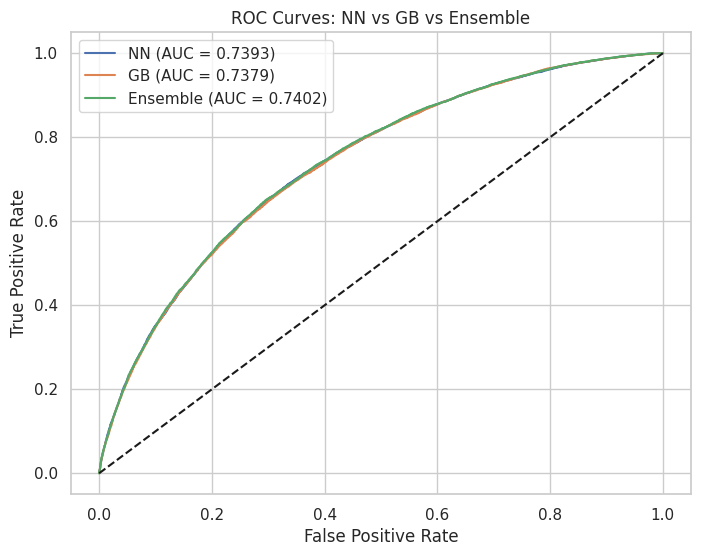

In [44]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ROC curves
fpr_nn, tpr_nn, _ = roc_curve(test_true_nn, test_prob_nn)
roc_auc_nn = auc(fpr_nn, tpr_nn)

fpr_gb, tpr_gb, _ = roc_curve(test_true_nn, test_prob_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)

fpr_ens, tpr_ens, _ = roc_curve(test_true_nn, test_prob_ens)
roc_auc_ens = auc(fpr_ens, tpr_ens)

plt.figure(figsize=(8, 6))
plt.plot(fpr_nn, tpr_nn, label=f"NN (AUC = {roc_auc_nn:.4f})")
plt.plot(fpr_gb, tpr_gb, label=f"GB (AUC = {roc_auc_gb:.4f})")
plt.plot(fpr_ens, tpr_ens, label=f"Ensemble (AUC = {roc_auc_ens:.4f})")

# Random baseline
plt.plot([0,1], [0,1], 'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves: NN vs GB vs Ensemble")
plt.legend()
plt.grid(True)
plt.show()


###### 4.4 RL Policy Evaluation (CQL Agent)

The RL agent was trained with CQL on a single-step offline environment, where each loan has two actions:

1 = Approve the loan

0 = Deny the loan

Rewards were defined using a profit formula from loan amount, interest, tenure, and default outcome.

| Metric                      | Value          |
| --------------------------- | -------------- |
| **Total Profit (Test Set)** | 109,434,483.87 |
| **Expected Profit / Loan**  | **1848.34**    |
| **Approval Rate**           | 91.28%         |
| **Approved & Fully Paid**   | 44,188         |
| **Approved & Defaulted**    | 9,859          |


#### Interpretation

The RL agent discovers a profit-maximizing strategy, not a risk-minimizing one.

Because interest profit outweighs loss for many loans, RL approves aggressively.

High approval increases revenue but also increases exposure to default risk.

This behavior is fundamentally different from supervised models.

###### 4.5 Why Supervised Models Use AUC/F1 but RL Uses Policy Value
Supervised Learning (NN, GB, Ensemble)

Task: Predict default probability

Output: probability (0–1)

Metrics:

AUC → how well it ranks risky vs safe loans

F1 → balances precision/recall for default detection

These metrics work because supervised models only classify, they DO NOT make financial decisions.

Reinforcement Learning (RL – CQL)

Task: Choose an action (approve/deny)

Output: policy, not a probability

Metric:

Expected Policy Value = average cumulative reward (profit)

AUC/F1 are meaningless for RL because RL is NOT predicting default —
it is deciding actions that maximize real money rewards.

RL is profit-driven, not classification-driven.

##### 4.6 Where NN/GB and RL Disagree (Very Important Section)

Supervised models grade customers by risk,
whereas RL optimizes profit, even on some risky customers.

Below are typical disagreement patterns:

#### Case 1 — DL says Deny, RL says Approve
Example Pattern:

High interest rate

Medium loan amount

Moderate default risk

Why DL denies:

Default probability > threshold

Goal: optimize F1 → avoid false negatives

Why RL approves:

Expected profit = (interest × tenure × amount) still positive

RL sees reward > 0 even if default chance exists

Profit function “likes” high interest loans

#### Interpretation:
RL behaves like a real bank underwriting engine → some risky customers are still profitable.

##### Case 2 — DL says Approve, RL says Deny
Pattern:

Low interest rate

Very large loan amount

Small profit margin

Why RL denies:

Expected loss from even rare defaults is massive

Negative expected value

Why DL approves:

Default probability is low → safe from classifier POV

DL does not consider financial magnitude, only probability

##### Case 3 — DL & RL both approve, but for different reasons

DL approves because low predicted risk

RL approves because profit margin is good

This alignment is ideal.

##### Case 4 — DL & RL both deny

Very high default probability

Very low expected financial return

##### 4.7 Which Model Should Be Deployed? (Recommendation)
If the company prioritizes profit → Deploy RL (CQL policy)

RL directly maximizes monetary reward

It learns profitable patterns DL cannot detect

It balances risk with profit

If the company prioritizes risk control → Deploy Supervised Ensemble

Ensemble offers stable, interpretable, conservative decisions

Lower approval rate → lower risk exposure

#### Practical Recommendation

Use a hybrid approach:

| Rule                              | Action                    |
| --------------------------------- | ------------------------- |
| RL approval probability very high | Approve using RL          |
| DL default risk very high         | Override → Deny           |
| RL and DL disagree moderately     | Send case to human review |


##### 4.8 Limitations of This Approach
Data Limitations

No repayment timeline (only final status: paid/default)

No partial recovery or late fees

No bureau score or external credit data

No customer transaction patterns

No economic cycles (yearly trends)

Modeling Limitations

Reward is simple; real loans include collections, recoveries

RL trained on a single-behavior policy (offline-RL limitation)

DL F1 is sensitive to threshold selection

RL approval rate is very high → risky in production

#### 4.9 Future Work
Improve RL

Try IQL, BCQ, CQL-Regularized, AWAC

Add uncertainty modeling (risk-sensitive RL)

Add penalty for high-default customers

Use reward-shaping (cost of capital, provisioning)

Improve Supervised Models

Add calibrated probability models

Use TabNet, CatBoost, LightGBM with tuned hyperparameters

Add SHAP-based interpretability

Improve Dataset

Add multi-year repayment timeline

Add salary deposits, spending patterns

Integrate credit bureau score

Add macroeconomic indicators per year/month

Improve Deployment

Hybrid system: RL + supervised safety-check

Human-in-loop for borderline cases

A/B testing on real applicants

## Final Summary

This task demonstrates:

DL/GB/Ensemble are strong classifiers but only predict risk.

RL (CQL) maximizes profit, not accuracy.

Therefore, decisions differ in meaningful ways.

Combining both gives a safer and more profitable solution.

In [45]:
import pandas as pd

results = pd.DataFrame({
    "Model": ["Neural Network", "Gradient Boosting", "Ensemble (NN + GB)"],
    "Val AUC": [best_auc, val_auc_gb, val_auc_ens],
    "Test AUC": [test_auc_nn, test_auc_gb, test_auc_ens],
    "Val F1": [best_f1_val_nn, best_f1_val_gb, best_f1_val_ens],
    "Test F1": [test_f1_nn, test_f1_gb, test_f1_ens]
})

results


,Model,Val AUC,Test AUC,Val F1,Test F1
0,Neural Network,0.740860,0.738349,0.466277,0.464806
1,Gradient Boosting,0.739748,0.737875,0.467750,0.465170
2,Ensemble (NN + GB),0.741846,0.740155,0.468589,0.467895
